In [107]:
import torch.utils.data as data_utils
import os
import numpy as np

data_path = os.getcwd() + "/data/"
frames = np.load(data_path + "cartpole_frames.npy")

In [ ]:
def sliding_window(a, window=4, step_size=1):
    '''
    Input is list of `shape` np arrays of length N
    Output is N - 4 x 4 x `shape`
    '''
    end = a.shape[0]
    #return np.moveaxis(np.stack([a[i:end-window+i+1:step_size] for i in range(window)]), 0, -1)
    # TimeDistributed looks at axis 1
    return np.moveaxis(np.stack([a[i:end-window+i+1:step_size] for i in range(window)]), 0, 1)

def eps_to_stacked_window(a, offset=False):
    if offset:
        return np.vstack([sliding_window(np.stack(x))[1:] for x in a])
    else:
        return np.vstack([sliding_window(np.stack(x))[:-1] for x in a])

windowed_frames = np.expand_dims(eps_to_stacked_window(frames), -1)
windowed_frames_next = np.expand_dims(eps_to_stacked_window(frames, offset=True), -1)
# windowed_actions = eps_to_stacked_window(actions)
assert windowed_frames_next.shape == windowed_frames.shape
print(windowed_frames.shape)

stk_frames = torch.from_numpy(windowed_frames)

In [8]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

if torch.cuda.is_available():
    print("Cuda ready")
    
USE_CUDA = True
BATCH_SIZE = 64
EPOCHS = 5

torch.manual_seed(1)
if USE_CUDA:
    torch.cuda.manual_seed(1)


kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

train_loader =

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if USE_CUDA:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if USE_CUDA:
    model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False


def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B:
    # https://arxiv.org/abs/1312.6114
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)
LOG_INTERVAL = 500

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if USE_CUDA:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        if USE_CUDA:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

Cuda ready
Train Epoch: 1 [0/60000 (0%)]	Loss: 549.210693
Train Epoch: 1 [32000/60000 (53%)]	Loss: 136.647308
====> Epoch: 1 Average loss: 148.1090
====> Test set loss: 119.4382
Train Epoch: 2 [0/60000 (0%)]	Loss: 122.028915
Train Epoch: 2 [32000/60000 (53%)]	Loss: 114.360924
====> Epoch: 2 Average loss: 116.0095
====> Test set loss: 111.9825
Train Epoch: 3 [0/60000 (0%)]	Loss: 118.039490
Train Epoch: 3 [32000/60000 (53%)]	Loss: 111.539803
====> Epoch: 3 Average loss: 111.5371
====> Test set loss: 109.7136
Train Epoch: 4 [0/60000 (0%)]	Loss: 114.115250
Train Epoch: 4 [32000/60000 (53%)]	Loss: 112.590012
====> Epoch: 4 Average loss: 109.4967
====> Test set loss: 107.9548
Train Epoch: 5 [0/60000 (0%)]	Loss: 104.463951
Train Epoch: 5 [32000/60000 (53%)]	Loss: 109.390930
====> Epoch: 5 Average loss: 108.2922
====> Test set loss: 107.7711
Train Epoch: 6 [0/60000 (0%)]	Loss: 110.807755
Train Epoch: 6 [32000/60000 (53%)]	Loss: 112.367950
====> Epoch: 6 Average loss: 107.4781
====> Test set lo

Variable containing:
 3
[torch.cuda.LongTensor of size 1 (GPU 0)]



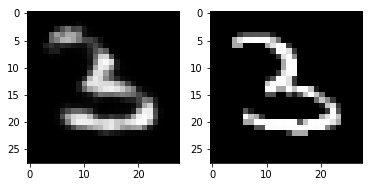

In [104]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i, data in enumerate(test_loader, 0):
    inputs, classes = data
    first_img = inputs[0].numpy()
    inputs, classes = Variable(inputs.resize_(BATCH_SIZE, 784)).cuda(), Variable(classes).cuda()
    a=fig.add_subplot(1,2,1)
    plt.imshow(model(inputs)[0].data[0].cpu().numpy().reshape(28, 28), cmap='gray')
    a=fig.add_subplot(1,2,2)
    plt.imshow(first_img.reshape(28,28), cmap='gray')
    print(classes[0])
    plt.show(block=True)
    break
    
